# **LAB 4 Analyze deployed models**

## Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import os

from bs4 import BeautifulSoup
import requests
import cv2
import PIL.Image
import urllib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import keras
from keras.datasets import cifar10
from keras import models, layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, Dropout, Activation, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

## Loading The Data

### Importing Train Data From CIFAR10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

''' We only need to keep 2 classes: Cats - Class 3, Dogs - Class 5 '''
train_picks = np.ravel(np.logical_or(y_train == 3, y_train == 5))  
y_train = np.array(y_train[train_picks] == 5,dtype=int)
x_train = x_train[train_picks]

x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
    
x_train = x_train.astype('float32')
x_train /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (10000, 32, 32, 3)
10000 train samples


### Visualizing The Train Data

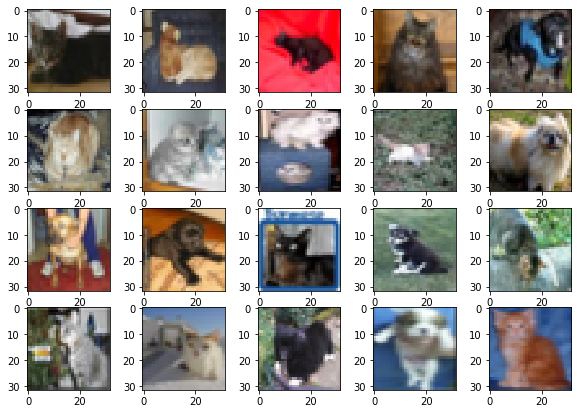

In [ ]:
fig  = plt.figure(figsize = (10, 7))
i = 0
for i in range(20):
    pl = fig.add_subplot(4, 5, i + 1)
    pl.imshow(x_train[i], cmap='gray')
    i += 1

### Loading The Dev and Test Set from ImageNet

#### Extracting Images From Website

In [ ]:
def url_to_image(url):
    webpage = urllib.request.urlopen(url) # Open the website URL
    image = np.asarray(bytearray(webpage.read()), dtype="uint8") # Load the image from the page
    image = cv2.imdecode(image, cv2.IMREAD_COLOR) # Decode to a more suitable format
    return image # Return the read image

In [ ]:
def get_images(url, n_samples, path):
    #Getting the image links and splitting them after converting to sting
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    str_soup = str(soup)
    
    urls = str_soup.split('\r\n')
    print('No. of URLs is:', len(urls))

    #Saving The Train Data
    i, count = 0, 0
    while 1:
        if count % 10 == 0: print('No. of Images Loaded: ', count)
        if not urls[i] == None:
            try:
                img = url_to_image(urls[i])
                if (len(img.shape)) == 3:
                    save_path = path + str(count) + '.jpg'
                    img = cv2.resize(img, (32, 32))
                    cv2.imwrite(save_path, img)
                    count += 1
            except: None

        i += 1
        if count >= n_samples: break

In [ ]:
# Cats
cats = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02123045"
cat_data = '/Users/nmims/Desktop/Semester VI/Deep Learning/Experiment 4/cats/cats'
get_images(cats, 200, cat_data)

No. of URLs is: 1524
No. of Images Loaded:  0
No. of Images Loaded:  10
No. of Images Loaded:  10
No. of Images Loaded:  10
No. of Images Loaded:  20
No. of Images Loaded:  30
No. of Images Loaded:  40
No. of Images Loaded:  50
No. of Images Loaded:  50
No. of Images Loaded:  60
No. of Images Loaded:  70
No. of Images Loaded:  70
No. of Images Loaded:  80
No. of Images Loaded:  80
No. of Images Loaded:  90
No. of Images Loaded:  90
No. of Images Loaded:  90
No. of Images Loaded:  100
No. of Images Loaded:  100
No. of Images Loaded:  110
No. of Images Loaded:  120
No. of Images Loaded:  130
No. of Images Loaded:  130
No. of Images Loaded:  140
No. of Images Loaded:  140
No. of Images Loaded:  140
No. of Images Loaded:  140
No. of Images Loaded:  150
No. of Images Loaded:  160
No. of Images Loaded:  170
No. of Images Loaded:  180
No. of Images Loaded:  180
No. of Images Loaded:  190


In [ ]:
# Dogs
dogs = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02084071"
dog_data = '/Users/nmims/Desktop/Semester VI/Deep Learning/Experiment 4/dogs/dogs'
get_images(dogs, 200, dog_data)

No. of URLs is: 1604
No. of Images Loaded:  0
No. of Images Loaded:  0
No. of Images Loaded:  0
No. of Images Loaded:  10
No. of Images Loaded:  20
No. of Images Loaded:  20
No. of Images Loaded:  30
No. of Images Loaded:  40
No. of Images Loaded:  50
No. of Images Loaded:  50
No. of Images Loaded:  60
No. of Images Loaded:  70
No. of Images Loaded:  80
No. of Images Loaded:  80
No. of Images Loaded:  80
No. of Images Loaded:  90
No. of Images Loaded:  100
No. of Images Loaded:  110
No. of Images Loaded:  110
No. of Images Loaded:  120
No. of Images Loaded:  120
No. of Images Loaded:  120
No. of Images Loaded:  130
No. of Images Loaded:  140
No. of Images Loaded:  140
No. of Images Loaded:  150
No. of Images Loaded:  150
No. of Images Loaded:  160
No. of Images Loaded:  170
No. of Images Loaded:  170
No. of Images Loaded:  180
No. of Images Loaded:  190
No. of Images Loaded:  190


#### Loading Images from Stored Folder to Code

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
    return images

In [ ]:
def get_array(folder):
    arrays = load_images_from_folder(folder)
    print('No of images found in class:', len(arrays))
    
    images =[]
    for i in range(len(arrays)):
        arr = arrays[i].reshape((arrays[i].shape[0] * arrays[i].shape[1] * arrays[i].shape[2]))
        images = np.append(images, arr)
    
    images = images.reshape((len(arrays), 32, 32, 3))
    return images, len(arrays)

In [ ]:
folder = '/Users/nmims/Desktop/Semester VI/Deep Learning/Experiment 4/cats'
cat, count = get_array(folder)
y_temp = np.array([0 for i in range(count)])
print('Read Cats')

folder = '/Users/nmims/Desktop/Semester VI/Deep Learning/Experiment 4/dogs'
dog, count = get_array(folder)
y = np.append(y_temp, np.array([1 for i in range(count)]))
print('Read Dogs')

x = np.vstack((cat, dog))
x = x / 255
print(x.shape)
print(y.shape)

No of images found in class: 200
Read Cats
No of images found in class: 200
Read Dogs
(400, 32, 32, 3)
(400,)


## Model Building

In [ ]:
x_dev, x_test, y_dev, y_test = train_test_split(x, y, shuffle = True, test_size = 0.5)
print(x_train.shape, x_dev.shape, x_test.shape)
print(y_train.shape, y_dev.shape, y_test.shape)

(10000, 32, 32, 3) (200, 32, 32, 3) (200, 32, 32, 3)
(10000, 1) (200,) (200,)


In [ ]:
con = Sequential()

# Layer 1
con.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu', input_shape = (32, 32, 3)))
con.add(MaxPooling2D(pool_size = (2, 2)))
con.add(layers.Dropout(0.25))

# Layer 2
con.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
con.add(MaxPooling2D(pool_size = (2, 2)))
con.add(layers.Dropout(0.25))

# Layer 3
'''con.add(Conv2D(filters = 256, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
con.add(MaxPooling2D(pool_size = (2, 2)))
con.add(layers.Dropout(0.25))'''
con.add(layers.Flatten())

# FC Layer 1, 2 & 3
# con.add(Dense(units = 1024, activation = 'relu'))
con.add(layers.Dropout(0.5))
con.add(Dense(units = 512, activation = 'relu'))
con.add(Dense(units = 256, activation = 'relu'))

# Output Layer
con.add(Dense(1, activation = "sigmoid"))

# Compiling Model
con.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
con.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

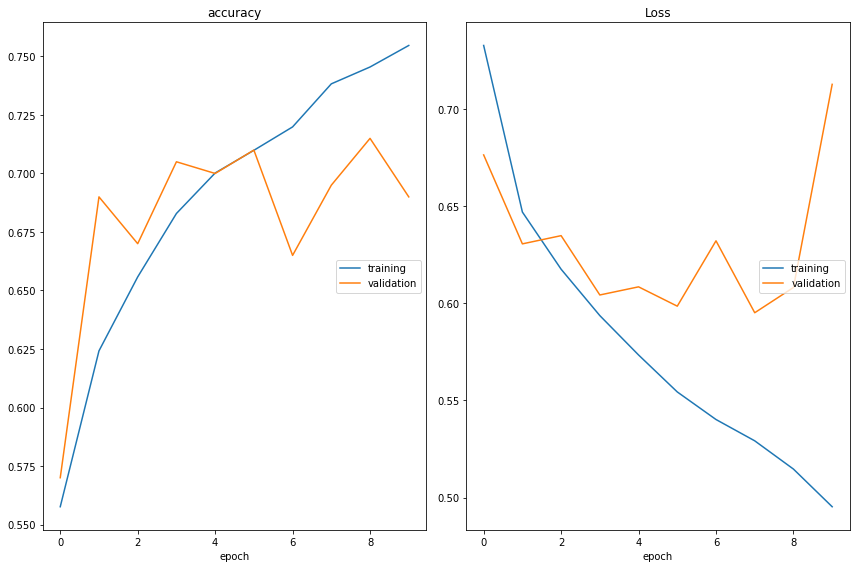

accuracy
	training         	 (min:    0.558, max:    0.755, cur:    0.755)
	validation       	 (min:    0.570, max:    0.715, cur:    0.690)
Loss
	training         	 (min:    0.495, max:    0.733, cur:    0.495)
	validation       	 (min:    0.595, max:    0.713, cur:    0.713)
100/100 [==============================] - 26s 262ms/step - loss: 0.4953 - accuracy: 0.7547 - val_loss: 0.7128 - val_accuracy: 0.6900
Epoch 00010: early stopping


In [ ]:
file = 'catDog.h5'
mc = ModelCheckpoint(filepath = file, monitor = 'val_accuracy', patience = 10, mode = 'max', save_best_only = True)
es = EarlyStopping(mode = 'auto', monitor = 'val_accuracy', verbose = 1, patience = 10, baseline = 0.9)
con.fit(x_train, y_train, validation_data = (x_dev, y_dev), epochs = 10, batch_size = 100, 
        callbacks = [PlotLossesKeras(), es, mc])

## Error Analysis

In [ ]:
con = load_model('catDog.h5')
er_dev = con.evaluate(x_dev, y_dev)[1]
er_test = con.evaluate(x_test, y_test)[1]

print('DEV ACCURACY:', er_dev * 100)
print('TEST ACCURACY:', er_test * 100)

7/7 [==============================] - 0s 15ms/step - loss: 0.6126 - accuracy: 0.7050


## Deployment

In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok

In [ ]:
procfile = 'web: gunicorn app:app'
procfiles= open("Procfile","w")
procfiles.write(procfile)
procfiles.close()

In [ ]:
app = Flask(__name__)
run_with_ngrok(app)

app.config['UPLOADS'] = 'uploads'

def bestModel():
    global mymodel
    mymodel = load_model('catDog.h5')

@app.route('/')
def home():
    return render_template('index.html')

def predicting(file):
    img = cv2.imread(file)
    img = cv2.resize(img, (32, 32))
    img = np.resize(img, (1, 32, 32, 3)) / 255
    pred = mymodel.predict(img)
    if pred > 0.5: return 'dog'
    else: return 'cat'

@app.route('/', methods = ['POST'])
def upload_files():
    file = request.files['file']
    animal = request.form['animal']
    for_file = int(animal)
    if for_file == 0: animal = 'cat'
    else: animal = 'dog'
    
    filepath = os.path.join(app.config['UPLOADS'], animal, file.filename)
    file.save(filepath)
    
    pred = predicting(filepath)
    
    # Documentating The Results
    doc = pd.read_csv('documentation.csv')
    if pred =='cat': out = 0
    else: out = 1
    doc.loc[len(doc)] = [file.filename, for_file, out]
    doc.to_csv('documentation.csv', index = False)
    
    return render_template('index.html', label = pred)

def updateModel():
    folder = '../Experiment 4/uploads/cat'
    cat, count = get_array(folder)
    y_temp = np.array([0 for i in range(count)])

    folder = '../Experiment 4/uploads/dog'
    dog, count = get_array(folder)
    y = np.append(y_temp, np.array([1 for i in range(count)]))

    x = np.vstack((cat, dog))
    x = x / 255
    mymodel.fit(x, y, epochs = 10)
    # If you want to save the newer version of the model overwriting the previous version
    # models.save_model(mymodel, 'catDog.h5')

if __name__ == '__main__':
    bestModel()
    '''
    Optional, if we want to retrain the model based on the input it has already saved from uploads
    Make sure after training on the upload data, the upload folder is cleared, otherwise it would train on the
    the same uploaded data again and again.
    '''
    # updateModel()
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/nmims/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/nmims/opt/anaconda3/lib/python3.7/threading.py", line 1177, in run
    self.function(*self.args, **self.kwargs)
  File "/Users/nmims/opt/anaconda3/lib/python3.7/site-packages/flask_ngrok.py", line 70, in start_ngrok
    ngrok_address = _run_ngrok()
  File "/Users/nmims/opt/anaconda3/lib/python3.7/site-packages/flask_ngrok.py", line 29, in _run_ngrok
    os.chmod(executable, 777)
FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/5b/kjb8xh8d7c7d5tsd6jpm0_9m0000gp/T/ngrok/ngrok'

